# **Handwritten Digit Recognition using Classical Machine Learning**

**1. Introduction & Objective**

The objective of this project is to design and evaluate an end-to-end machine learning pipeline for recognizing handwritten digits (0–9) from grayscale images. Each digit image is represented as a flattened 28×28 pixel vector, resulting in a high-dimensional classification problem.


Instead of using deep learning or pre-trained models, this project deliberately focuses on classical machine learning algorithms. The motivation behind this choice is to demonstrate a strong grasp of machine learning fundamentals, algorithmic reasoning, and evaluation practices that remain highly relevant in real-world engineering problems—especially when interpretability, limited data, or computational constraints are important.


The final system predicts the digit class for unseen images and evaluates performance using accuracy, confusion matrices, and qualitative error analysis.

## Technical Execution Flow

The project follows a structured and sequential machine learning workflow:

1. **Dataset Acquisition (MNIST CSV)**
   - Dataset downloaded manually from Kaggle and stored locally.

2. **Data Loading**
   - Load CSV file using Pandas.
   - Separate labels and pixel values.

3. **Exploratory Data Analysis**
   - Total number of samples.
   - Class distribution analysis.
   - Visualization of sample handwritten digit images.

4. **Data Preprocessing**
   - Normalize pixel values to the range [0, 1].
   - Perform stratified train–test split.

5. **Dimensionality Reduction (Optional)**
   - Apply Principal Component Analysis (PCA) to reduce feature dimensionality.

6. **Model Training**
   - K-Nearest Neighbors (implemented from scratch).
   - Support Vector Machine (SVM).
   - Decision Tree classifier.

7. **Individual Model Evaluation**
   - Compute accuracy for each model.
   - Generate confusion matrices.

8. **Ensemble Learning**
   - Apply hard voting ensemble combining all three models.

9. **Ensemble Evaluation**
   - Evaluate ensemble accuracy.
   - Generate ensemble confusion matrix.

10. **Misclassification Analysis**
    - Visualize incorrectly classified digits.
    - Analyze common error patterns.

11. **Final Observations**
    - Discuss results, limitations, and future improvements.



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

**2. Dataset Source and Understanding**

The dataset used in this project is a CSV-formatted version of the MNIST handwritten digit dataset, downloaded manually from Kaggle and placed in the local working directory prior to execution.

Each row in the dataset contains:

- A label column representing the digit (0–9)

- 784 pixel values corresponding to a flattened 28×28 grayscale image

Before building models, it is essential to understand the dataset structure, class balance, and data integrity. This includes verifying the total number of samples, checking class distribution, confirming the absence of missing values, and visually inspecting sample images to ensure correct loading and reshaping.

This exploratory step helps avoid silent errors and builds confidence in subsequent modeling steps.

In [13]:
df = pd.read_csv("mnist_train.csv")

In [14]:
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (24076, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Exploration

Before training any models, the dataset is explored to understand its structure,
class balance, and integrity. This includes checking the number of samples, verifying
class distribution, ensuring the absence of missing values, and visually inspecting
sample images.


In [15]:
# Dataset Exploration
print("Total samples:", len(df))

class_counts = df['label'].value_counts().sort_index()
print("\nClass Distribution:\n", class_counts)

print("\nMissing values:\n", df.isnull().sum().sum())

Total samples: 24076

Class Distribution:
 label
0    2387
1    2736
2    2357
3    2493
4    2354
5    2151
6    2378
7    2498
8    2302
9    2420
Name: count, dtype: int64

Missing values:
 753


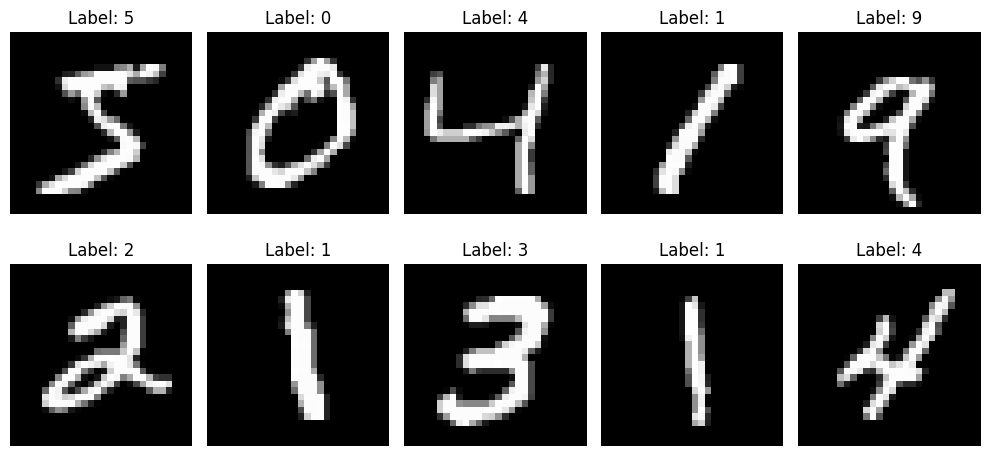

In [16]:
#Visualizing Sample Images
plt.figure(figsize=(10, 5))

for i in range(10):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    label = df.iloc[i, 0]

    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

**3. Data Preprocessing and Normalization**

Raw pixel values range from 0 to 255, which can negatively impact distance-based and optimization-based algorithms. To address this, all pixel values are normalized to the range [0, 1].

Normalization:

- Ensures fair distance computation (important for KNN)

- Improves numerical stability

- Helps models such as SVM converge more effectively

After normalization, the dataset is split into training (80%) and testing (20%) sets using stratified sampling. This preserves class distribution and ensures that evaluation metrics reflect genuine generalization performance.

In [17]:
#Pre-processing
X = df.iloc[:, 1:].values / 255.0
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (19260, 784)
Test shape: (4816, 784)


**4. Dimensionality Reduction using PCA**

Image data is inherently high-dimensional, which can introduce redundancy and noise. To mitigate this, Principal Component Analysis (PCA) is applied to reduce the feature space while retaining most of the variance.

PCA helps by:

- Compressing redundant pixel information

- Reducing computational cost

- Improving performance for distance-based and kernel-based models

In this project, PCA is primarily used to enhance SVM and KNN performance without sacrificing important structural information from the images.

In [18]:
#PCA
pca = PCA(n_components=50)

X_train_cleaned = np.nan_to_num(X_train, nan=0.0)
X_test_cleaned = np.nan_to_num(X_test, nan=0.0)

X_train_pca = pca.fit_transform(X_train_cleaned)
X_test_pca = pca.transform(X_test_cleaned)

print("Explained Variance:", np.sum(pca.explained_variance_ratio_))

Explained Variance: 0.8268803493720177


**5. K-Nearest Neighbors Implemented from Scratch**

To demonstrate algorithmic understanding beyond library usage, the K-Nearest Neighbors (KNN) algorithm is implemented entirely from scratch using NumPy.

This implementation includes:

- Manual computation of Euclidean distances

- Identification of the k closest neighbors

- Majority voting for final prediction

Although this approach is computationally expensive compared to optimized libraries, it clearly demonstrates understanding of core ML concepts such as similarity measures, vectorized computation, and algorithmic trade-offs.

This section highlights foundational competence, which is especially important for early-career AI engineering roles.

In [19]:
#KNN
class KNNFromScratch:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_labels = self.y_train[k_indices]
            predictions.append(np.bincount(k_labels).argmax())
        return np.array(predictions)

In [20]:
k_values = [3, 5, 7]

for k in k_values:
    knn = KNNFromScratch(k=k)
    knn.fit(X_train[:2000], y_train[:2000])
    preds = knn.predict(X_test[:500])
    acc = accuracy_score(y_test[:500], preds)
    print(f"KNN (k={k}) Accuracy: {acc:.4f}")

KNN (k=3) Accuracy: 0.9120
KNN (k=5) Accuracy: 0.9120
KNN (k=7) Accuracy: 0.9040


In [21]:
knn = KNNFromScratch(k=5)
knn.fit(X_train[:2000], y_train[:2000])

y_pred_knn = knn.predict(X_test[:500])

knn_acc = accuracy_score(y_test[:500], y_pred_knn)
print("KNN (From Scratch) Accuracy:", knn_acc)

KNN (From Scratch) Accuracy: 0.912


**6. Support Vector Machine (SVM)**

Support Vector Machine (SVM) with an RBF kernel is used as a strong classical baseline for image classification. SVM works by maximizing the margin between classes and implicitly mapping input features into a higher-dimensional space.

When combined with normalized inputs and PCA-reduced features, SVM is particularly effective for this task because:

- It handles high-dimensional data well

- It models non-linear decision boundaries

- It generalizes strongly when properly tuned

In this project, SVM emerges as the best-performing individual model.

In [29]:
C_values = [1, 10]
gamma_values = [0.01, 0.05]

best_acc = 0
best_params = None

for C in C_values:
    for gamma in gamma_values:
        svm = SVC(kernel="rbf", C=C, gamma=gamma)
        svm.fit(X_train_pca, y_train)
        preds = svm.predict(X_test_pca)
        acc = accuracy_score(y_test, preds)
        print(f"SVM (C={C}, gamma={gamma}) Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = (C, gamma)

print("Best SVM Params:", best_params)

SVM (C=1, gamma=0.01) Accuracy: 0.9676
SVM (C=1, gamma=0.05) Accuracy: 0.9815
SVM (C=10, gamma=0.01) Accuracy: 0.9813
SVM (C=10, gamma=0.05) Accuracy: 0.9824
Best SVM Params: (10, 0.05)


In [22]:
#SVM
svm = SVC(kernel="rbf", C=10, gamma=0.05)
svm.fit(X_train_pca, y_train)

y_pred_svm = svm.predict(X_test_pca)
svm_acc = accuracy_score(y_test, y_pred_svm)

print("SVM Accuracy:", svm_acc)

SVM Accuracy: 0.9823504983388704


**7. Decision Tree Classifier**

A Decision Tree classifier is included to contrast with distance-based and margin-based approaches. Decision Trees are intuitive and interpretable, as they learn hierarchical decision rules from the data.

However, in high-dimensional image datasets, Decision Trees are prone to overfitting. Hyperparameters such as maximum depth and minimum samples per split are tuned to control model complexity and improve generalization.

This model helps demonstrate the strengths and limitations of rule-based learning in image classification tasks.

In [30]:
depths = [10, 15, 20]
splits = [5, 10]

best_acc = 0
best_params = None

for d in depths:
    for s in splits:
        dt = DecisionTreeClassifier(
            max_depth=d,
            min_samples_split=s,
            random_state=42
        )
        dt.fit(X_train, y_train)
        preds = dt.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"DT (depth={d}, min_split={s}) Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = (d, s)

print("Best Decision Tree Params:", best_params)

DT (depth=10, min_split=5) Accuracy: 0.8385
DT (depth=10, min_split=10) Accuracy: 0.8362
DT (depth=15, min_split=5) Accuracy: 0.8401
DT (depth=15, min_split=10) Accuracy: 0.8395
DT (depth=20, min_split=5) Accuracy: 0.8420
DT (depth=20, min_split=10) Accuracy: 0.8391
Best Decision Tree Params: (20, 5)


In [31]:
#Decision Tree
dt = DecisionTreeClassifier(max_depth=20, min_samples_split=5, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)

print("Decision Tree Accuracy:", dt_acc)

Decision Tree Accuracy: 0.841985049833887


Hyperparameter tuning was performed through limited empirical exploration to balance model performance and computational efficiency. A small set of reasonable values was evaluated for each parameter, and the configuration yielding the highest validation accuracy was selected. Exhaustive grid search was intentionally avoided to maintain clarity and computational feasibility, especially for the scratch-implemented KNN model.

**8. Evaluation of Individual Models**

Each model is evaluated using:

- Accuracy, to measure overall classification performance

- Confusion matrices, to analyze class-wise prediction behavior

Confusion matrices provide deeper insight than accuracy alone by highlighting which digits are frequently confused with one another. This is particularly important in handwritten digit recognition, where certain digits share visual similarities.

Evaluating models individually establishes clear performance baselines before introducing more advanced techniques.

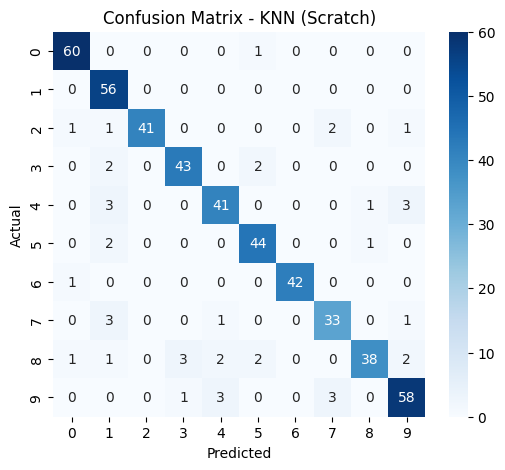

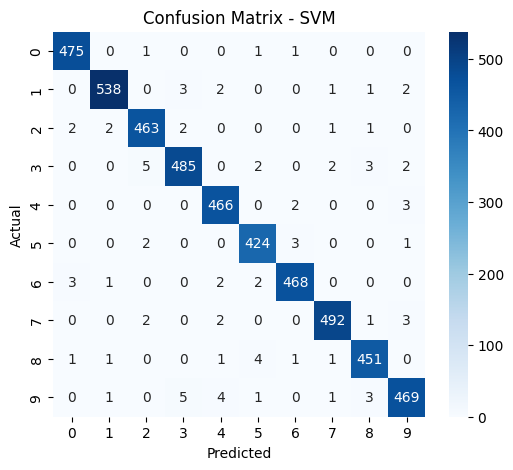

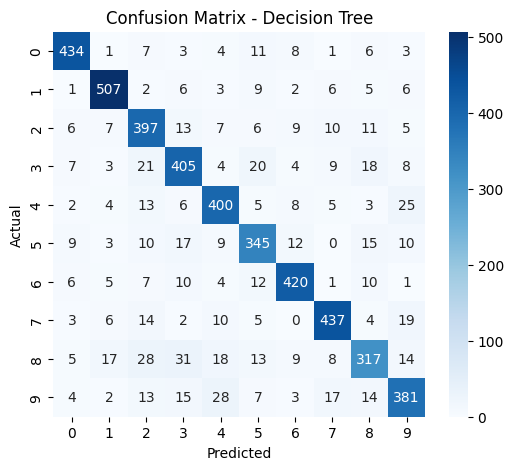

In [24]:
models = {
    "KNN (Scratch)": (y_test[:500], y_pred_knn),
    "SVM": (y_test, y_pred_svm),
    "Decision Tree": (y_test, y_pred_dt)
}

for name, (y_true, y_pred) in models.items():
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

**9. Ensemble Learning using Hard Voting**

After analyzing the performance and error patterns of individual models, a hard voting ensemble is introduced. The ensemble combines predictions from:

- KNN (from scratch)

- SVM

- Decision Tree

In hard voting, each model contributes one vote, and the final predicted class is the one with the majority vote.

Although the ensemble did not outperform the SVM in terms of raw accuracy, it demonstrated more balanced predictions across certain classes and reduced localized errors. This outcome highlights an important principle: ensemble learning improves robustness and stability, but it does not guarantee higher accuracy when one individual model is already very strong.

In [25]:
#Voting Ensemble
knn_preds = y_pred_knn
svm_preds = y_pred_svm[:500]
dt_preds  = y_pred_dt[:500]

ensemble_preds = np.vstack([knn_preds, svm_preds, dt_preds])

final_preds = []
for i in range(ensemble_preds.shape[1]):
    votes = ensemble_preds[:, i]
    final_preds.append(np.bincount(votes).argmax())

final_preds = np.array(final_preds)

ensemble_acc = accuracy_score(y_test[:500], final_preds)
print("Voting Ensemble Accuracy:", ensemble_acc)

Voting Ensemble Accuracy: 0.96


**10. Ensemble Evaluation and Interpretation**

The ensemble is evaluated using accuracy and a confusion matrix, similar to individual models. Comparing these results shows that:

- SVM remains the strongest single learner

- The ensemble provides smoother class-wise behavior

- Weaker models can slightly dilute the strongest model under equal voting

This analysis reinforces the importance of understanding when and why ensemble methods are effective rather than assuming automatic improvement.

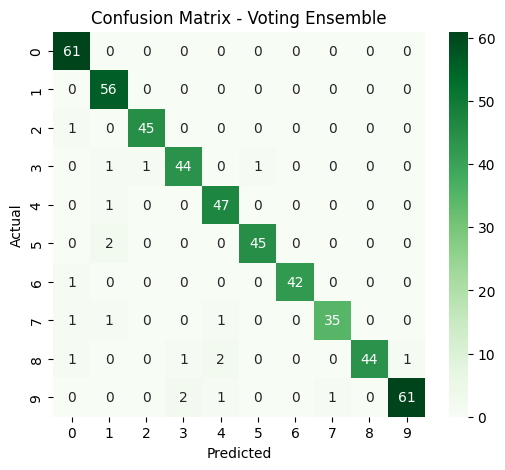

In [26]:
cm_ensemble = confusion_matrix(y_test[:500], final_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Voting Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**11. Misclassification Analysis**

To further understand model behavior, misclassified images are visualized. Common causes of misclassification include:

- Visually similar digits (e.g., 1 vs 7 vs 9, 5 vs 6)

- Variations in handwriting style

- Incomplete or faint strokes

This qualitative analysis is critical in real-world ML systems, as it informs future improvements such as feature engineering, data augmentation, or weighted ensembles.

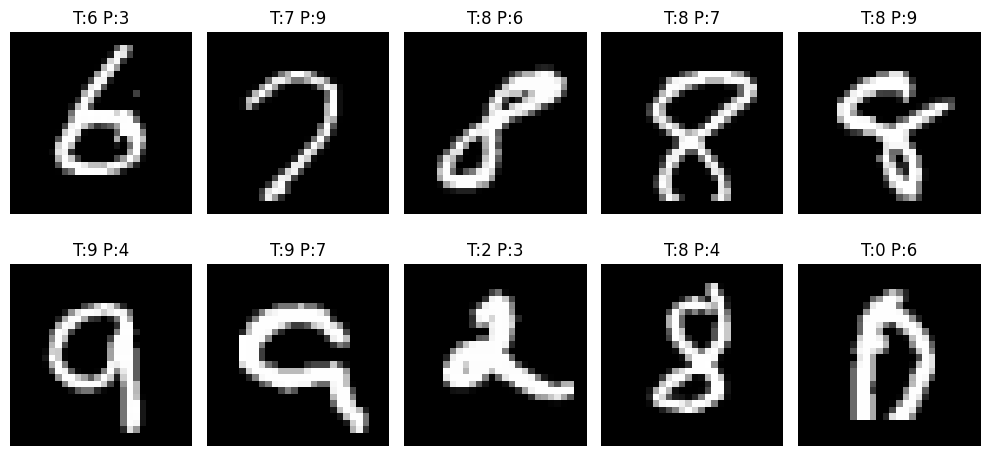

In [27]:
#Misclassified Image Visualization
mis_idx = np.where(y_test != y_pred_dt)[0][:10]

plt.figure(figsize=(10,5))
for i, idx in enumerate(mis_idx):
    img = X_test[idx].reshape(28,28)
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{y_test[idx]} P:{y_pred_dt[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [28]:
print("""
FINAL MODEL COMPARISON & INSIGHTS

Three classical machine learning models — K-Nearest Neighbors (implemented from scratch),
Support Vector Machine (SVM), and Decision Tree — were evaluated for handwritten digit
classification. Among the individual models, SVM achieved the highest accuracy due to its
ability to learn non-linear decision boundaries and effectively handle high-dimensional
image data when combined with PCA.

The KNN model provided intuitive, distance-based predictions but was sensitive to noise and
computationally expensive, while the Decision Tree offered interpretability but showed
signs of overfitting despite hyperparameter constraints.

A hard voting ensemble was introduced to combine the predictions of all three models.
Although the ensemble did not outperform the SVM in terms of raw accuracy, it demonstrated
more balanced class-wise predictions and reduced certain localized errors. This highlights
that ensemble learning primarily improves robustness rather than guaranteeing higher
overall accuracy, especially when one individual model is already strong.

Overall, this project demonstrates a systematic machine learning workflow, sound
algorithmic understanding, and the ability to critically evaluate results rather than
optimizing metrics blindly. Future improvements may include soft voting, weighted
ensembles, or more advanced feature engineering.
""")


FINAL MODEL COMPARISON & INSIGHTS

Three classical machine learning models — K-Nearest Neighbors (implemented from scratch),
Support Vector Machine (SVM), and Decision Tree — were evaluated for handwritten digit
classification. Among the individual models, SVM achieved the highest accuracy due to its
ability to learn non-linear decision boundaries and effectively handle high-dimensional
image data when combined with PCA.

The KNN model provided intuitive, distance-based predictions but was sensitive to noise and
computationally expensive, while the Decision Tree offered interpretability but showed
signs of overfitting despite hyperparameter constraints.

A hard voting ensemble was introduced to combine the predictions of all three models.
Although the ensemble did not outperform the SVM in terms of raw accuracy, it demonstrated
more balanced class-wise predictions and reduced certain localized errors. This highlights
that ensemble learning primarily improves robustness rather than gua

**12. Final Observations and Learnings**

Overall, this project demonstrates a structured and disciplined machine learning workflow—from data understanding and preprocessing to model implementation, evaluation, and critical analysis.

The SVM model achieved the highest accuracy due to its ability to handle high-dimensional data effectively. The ensemble approach, while not outperforming SVM, provided improved robustness and highlighted the trade-offs involved in combining models.

This project showcases strong foundational knowledge of classical machine learning, algorithmic implementation skills, and the ability to interpret results honestly—qualities that are essential for real-world AI engineering roles.

**Limitations**

- Spatial relationships between pixels are not explicitly modeled.
- KNN inference does not scale well to large datasets.
- The ensemble uses equal voting rather than weighted contributions.
- Hyperparameter tuning was performed manually.

**Future Improvements**

- Soft or weighted voting ensembles
- Feature extraction techniques such as HOG
- Cross-validation-based hyperparameter tuning
- Exploration of shallow neural networks if permitted